In [ ]:
from typing import List, Dict, Any
from langgraph.graph import StateGraph, MessagesState, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

from IPython.display import Image

# Simple Agent with Tool Calling

This notebook demonstrates the basics of building an agent with LangGraph:
- How to define tools that an agent can use
- How to create a simple agent loop (model → tools → model)
- How to use conditional routing to decide when to call tools

**Goal**: Build an agent that can solve simple math problems by calling the `add_numbers` tool.

In [ ]:
@tool
def add_numbers(a: int, b: int) -> int:
    """Return the sum of two integers."""
    return a + b

@tool
def top_k_words(text: str, k: int = 3) -> List[str]:
    """Return the top-k most frequent words in the text (toy demo)."""
    from collections import Counter
    words = [w.lower() for w in text.split()]
    return [w for w, _ in Counter(words).most_common(k)]

TOOLS = [add_numbers, top_k_words]
TOOL_MAP = {t.name: t for t in TOOLS}


## Define Tools

Tools are functions the agent can call. The `@tool` decorator makes them available to the LLM.

## Define Graph Nodes

Create the nodes that will be part of our agent workflow:
- **Model node**: Calls the LLM, which can decide to use tools or respond directly
- **Tools node**: Executes any tools requested by the model
- **Conditional routing**: Decides whether to call tools or end the conversation

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(TOOLS)

def call_llm(state: MessagesState) -> Dict[str, Any]:
    """Append an AI message; may include tool_calls."""
    ai = llm.invoke(state["messages"])
    return {"messages": [ai]}

In [ ]:
def call_tools(state: MessagesState) -> Dict[str, Any]:
    """Execute any tool_calls from the last AI message."""
    last = state["messages"][-1]
    tool_msgs = []
    for tc in getattr(last, "tool_calls", []) or []:
        name, args, tc_id = tc["name"], tc["args"], tc["id"]
        result = TOOL_MAP[name].invoke(args)  # sync execution
        tool_msgs.append(
            ToolMessage(
                content=str(result),
                name=name,
                tool_call_id=tc_id,
            )
        )
    return {"messages": tool_msgs}

## Build the Graph

Connect all the pieces to create the agent workflow:
1. Start with the model node
2. After model: conditionally route to tools or END
3. After tools: loop back to model

This creates the pattern: **model → tools → model → END**

In [ ]:
def needs_tool(state: MessagesState) -> str:
    last = state["messages"][-1]
    has_calls = bool(getattr(last, "tool_calls", []) or [])
    decision = "tools" if has_calls else END
    # print(f"[CONDITIONAL] After 'model' → routing to: {decision}")
    return "tools" if has_calls else END

## Run the Agent

Watch the agent execute step by step:
1. Receive the question "What is 4 + 5?"
2. Model decides to call `add_numbers` tool
3. Tool executes and returns 9
4. Model provides final answer

## Visualize the Graph

View the agent's workflow as a diagram showing the connections between nodes.

In [ ]:
def get_graph():
    workflow = StateGraph(state_schema=MessagesState)
    workflow.add_node("model", call_llm)
    workflow.add_node("tools", call_tools)

    workflow.set_entry_point("model")
    workflow.add_conditional_edges("model", needs_tool, {"tools": "tools", END: END})
    workflow.add_edge("tools", "model")  # after tools, go back to model

    checkpointer = MemorySaver()
    graph = workflow.compile(checkpointer=checkpointer)
    return graph


In [ ]:
token_tally = {"p": 0, "c": 0, "t": 0}
seen_ids = set()  # to avoid reprinting old messages

def log_step(chunk: dict):
    # Handle both "updates" and "values" stream modes
    if "__end__" in chunk:
        return
    
    # If chunk has node names as keys (updates mode)
    if any(key in ["model", "tools", "__end__"] for key in chunk.keys()):
        for node, state in chunk.items():
            if node == "__end__":
                continue
            _process_messages(node, state)
    else:
        # If chunk is the complete state (values mode)
        _process_messages("STEP", chunk)

def _process_messages(node: str, state):
    messages = state.get("messages", []) if isinstance(state, dict) else []
    for m in messages:
        if not hasattr(m, "id") or m.id in seen_ids:
            continue
        seen_ids.add(m.id)
        msg = ""

        if isinstance(m, HumanMessage):
            print(f"[{node.upper()}] USER → {m.content}")
        elif isinstance(m, AIMessage):
            if getattr(m, "tool_calls", None):
                for tc in m.tool_calls:
                    msg += f"[{node.upper()}] MODEL → {tc['name']}(...)"
            if m.content:
                msg += f"[{node.upper()}] MODEL → {m.content}"

            usage = (m.response_metadata or {}).get("token_usage", {})
            p, c, t = usage.get("prompt_tokens", 0), usage.get("completion_tokens", 0), usage.get("total_tokens", 0)
            token_tally["p"] += p
            token_tally["c"] += c
            token_tally["t"] += t
            if t > 0:
                msg += f" ⎯ tokens: {p}/{c}/{t}"

        elif isinstance(m, ToolMessage):
            preview = m.content[:80] + ("…" if isinstance(m.content, str) and len(m.content) > 80 else "")
            msg += f"[{node.upper()}] TOOL ← {m.name}: {preview}"

    if msg:
        print(msg)


In [ ]:
graph = get_graph()
initial_state = {"messages": [HumanMessage(content="What is 4 + 5?")]}
config = {"configurable": {"thread_id": "1"}}  # for MemorySaver checkpointing

for chunk in graph.stream(initial_state, config=config, stream_mode="values"):
    log_step(chunk)

[STEP] USER → What is 4 + 5?
[CONDITIONAL] After 'model' → routing to: tools
[STEP] MODEL → add_numbers(...) ⎯ tokens: 96/18/114
[STEP] TOOL ← add_numbers: 9
[CONDITIONAL] After 'model' → routing to: __end__
[STEP] MODEL → 4 + 5 equals 9. ⎯ tokens: 123/9/132


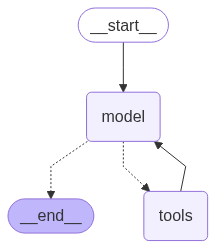

In [ ]:
Image(graph.get_graph().draw_mermaid_png())
